In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2korszml
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2korszml


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

## AMI masked dataset 
here we define a dataset for pythorch based on the AMI dataset but we have also created the mask for the ears.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/biosys
%ls

Mounted at /content/drive
/content/drive/MyDrive/biosys
 02-03-21_d2-1_b2-1_dsed_manseed_ep20
 04-03-21_d2-1_b8-2_dsed_manseed_curr-bis_ep20
 04-03-21_d2-1_b8-2_dsed_manseed_curr-bis_from20_ep30
 07-03-21_d2-1_b8-2_dsed_manseed_curr-bis_from30_ep40
 07-03-21_d2-1_b8-2_dsed_manseed_curr-bis_from40_ep50
 09-03-22_davide_crop/
 10-03-22_d2-1_b8-2_AWE_start0_ep14
 10-03-22_d2-1_b8-2_AWE_start0_ep16
 10-03-22_d2-1_b8-2_AWE_start0_ep18
 10-03-22_d2-1_b8-2_AWE_start0_ep19
 10-03-22_d2-1_b8-2_AWE_start0_ep4
 10-03-22_d2-1_b8-2_AWE_start0_ep9
 10-03-22_d2-1_b8-2_AWE_start20_ep24
 10-03-22_d2-1_b8-2_AWE_start20_ep29
 10-03-22_d2-1_b8-2_AWE_start20_ep34
 10-03-22_d2-1_b8-2_AWE_start20_ep35
 10-03-22_d2-1_b8-2_AWE_start20_ep37
 10-03-22_d2-1_b8-2_AWE_start_from0_ep20
 10-03-22_d2-1_b8-2_AWE_start_from20_ep40
 AMI_dataset_final.zip
 AMI_masked/
 AMI_masked.zip
 AWEForSegmentation/
'Biometrics Systems'@
 coco_eval.py
 coco_utils.py
 ear_segmentation.onnx
 engine.py
 __pycache__/
 transforms.py
 util

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
AMI_masked/
  AMI_masks/
    106_zoom_ear.png
    ...
  AMI_color/
    106_zoom_ear_mask.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
from PIL import Image
Image.open('AMI_masked/AMI_color/000_back_ear._flip.png')

In [ ]:
mask = Image.open('/content/drive/MyDrive/biosys/AWEForSegmentation/trainannot/0014.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0,   # index 1 is red
    255, 255, 0,   # index 2 is yellow
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class AMI_masked(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "AMI_color"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "AMI_masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "AMI_color", self.imgs[idx])
        mask_path = os.path.join(self.root, "AMI_masks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        #img = np.array(img,dtype=np.float64)/255
        #img = torch.from_numpy(img)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask_img = Image.open(mask_path)

        mask = np.array(mask_img)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class AWE_for_segmentation_test(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "test"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "testannot"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "test", self.imgs[idx])
        mask_path = os.path.join(self.root, "testannot", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        #img = np.array(img,dtype=np.float64)/255
        #img = torch.from_numpy(img)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask_img = Image.open(mask_path)

        mask = np.array(mask_img)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
class AWE_for_segmentation_train(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "train"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "trainannot"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "train", self.imgs[idx])
        mask_path = os.path.join(self.root, "trainannot", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        #img = np.array(img,dtype=np.float64)/255
        #img = torch.from_numpy(img)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask_img = Image.open(mask_path)

        mask = np.array(mask_img)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from engine import train_one_epoch, evaluate
import utils
import transforms as T
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(f'in_features {in_features}')
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    #print(f'model summary\n{model}')

    return model
  
def get_transform():
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [ ]:
#dataset_used = 'AMI'
dataset_used = 'AWE'

if dataset_used == 'AMI':
  # use our dataset and defined transformations
  dataset_original = AMI_masked('AMI_masked/',get_transform())
  dataset, dataset_test = torch.utils.data.random_split(dataset_original, [933, 467], generator=torch.Generator().manual_seed(20))
if dataset_used == 'AWE':
  dataset = AWE_for_segmentation_train('AWEForSegmentation',get_transform())
  dataset_test = AWE_for_segmentation_test('AWEForSegmentation',get_transform())

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has three classes only - background and ear l ear r and 
num_classes = 3

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optim_sele = 'sgd'# 'sgd'

if optim_sele == 'sgd':
  optimizer = torch.optim.SGD(params, lr=0.00014 ,#0.0003, #0.00005,#0.005,#0.005,
                              momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=4,
                                               gamma=0.6)#gamma=0.1)

in_features 1024


In [ ]:
path_to_load = '/content/drive/MyDrive/biosys/07-03-21_d2-1_b8-2_dsed_manseed_curr-bis_from40_ep50'
model.load_state_dict(torch.load(path_to_load))
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 20 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    #save model at each epoch
    if epoch in [1,3]:
      torch.save(model.state_dict(), f'./10-03-22_d2-1_b8-2_AWE_start20_ep{34+epoch}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/94]  eta: 0:12:50  lr: 0.000002  loss: 0.0739 (0.0739)  loss_classifier: 0.0083 (0.0083)  loss_box_reg: 0.0063 (0.0063)  loss_mask: 0.0590 (0.0590)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 8.1933  data: 2.0845  max mem: 9271
Epoch: [0]  [50/94]  eta: 0:03:59  lr: 0.000077  loss: 0.0755 (0.0751)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0075 (0.0076)  loss_mask: 0.0587 (0.0583)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0005)  time: 5.3999  data: 0.0460  max mem: 9608
Epoch: [0]  [93/94]  eta: 0:00:05  lr: 0.000140  loss: 0.0762 (0.0756)  loss_classifier: 0.0090 (0.0088)  loss_box_reg: 0.0075 (0.0076)  loss_mask: 0.0573 (0.0585)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 5.3053  data: 0.0447  max mem: 9608
Epoch: [0] Total time: 0:08:27 (5.4036 s / it)
creating index...
index created!
Test:  [  0/125]  eta: 0:02:11  model_time: 0.7253 (0.7253)  evaluator_time: 0.0090 (0.0090)

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
torch.save(model.state_dict(), './10-03-22_d2-1_b8-2_AWE_start_from20_ep40')

In [ ]:
# pick one image from the test set
img, _ = dataset_test[100]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[ 71.6734, 154.9604, 370.2737, 652.7448],
          [ 87.6593,  14.0914, 452.9260, 499.0012],
          [  3.9155, 371.4584, 406.5837, 627.1754],
          [143.9537,   3.0167, 425.1884, 309.1882],
          [ 50.5648, 287.6136, 443.5711, 554.2732],
          [ 14.0956, 398.2119, 274.2922, 701.7232],
          [ 68.9850, 139.4350, 492.0000, 401.4061],
          [256.0160,  35.3221, 461.3343, 517.3963],
          [112.6358, 415.9391, 319.6685, 644.1979],
          [ 57.6994, 487.0312, 345.0052, 609.7068],
          [ 36.9491, 150.6579, 234.2829, 626.4887],
          [139.0109, 356.3292, 359.6602, 588.5819],
          [  0.0000, 519.2313, 387.1998, 697.3928],
          [ 67.7270, 362.1311, 282.2401, 587.8981],
          [153.8088, 172.7127, 320.0643, 416.2603],
          [ 56.9754, 477.3180, 214.0898, 701.5693],
          [229.3804, 312.1419, 398.7838, 553.2684],
          [ 70.6538,  18.1502, 331.1825, 346.7518],
          [118.5353, 116.0520, 279.1688, 355.7943],
   

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

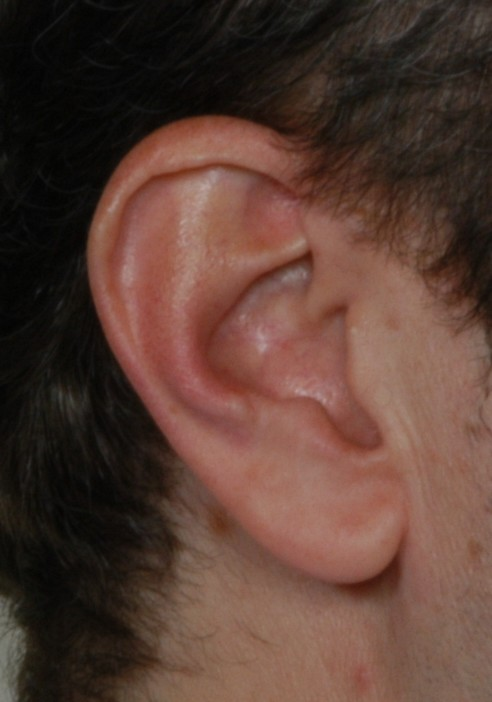

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

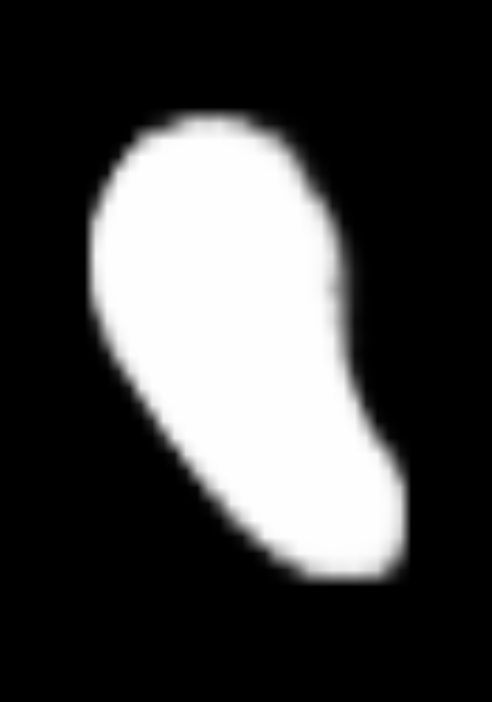

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
img = Image.open('/content/drive/MyDrive/Biometrics Systems/dataset/001/02.png').convert("RGB")
trasform = get_transform()
img,_= trasform(img, None)
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction


[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'masks': tensor([], device='cuda:0', size=(0, 1, 322, 185)),
  'scores': tensor([], device='cuda:0')}]